In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch
import statsmodels.api as sm
import os.path as path
from sys import path as syspath

syspath.append('../src/')

from analysis_pipeline import Analysis
from figure_utils import save_figure
from scipy.stats import chisquare, pearsonr, shapiro, normaltest, kstest, norm, sem
# from main_utils import Dendrite
from markov_utils import bin_data, bin_clip_func
from distance_utils import create_dynamic_events_matrix, create_persistent_synapse_matrix
from markov_utils import markov_pipeline, run_chain, compute_stationary_dist, get_stationary_arr

from kesten_utils import linear_regress, run_kesten

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'

from my_colormaps import viridis

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

`Analysis` object will fit Kesten process upon initialization due to default arguments

In [4]:
# Load weights
pyr_weights = np.load(os.path.expanduser('../data/weight_matrices/quantile_4060_pyr.npz'))
pv_weights = np.load(os.path.expanduser('../data/weight_matrices/quantile_4060_pv.npz'))
pyr_dendrite_map = np.load(os.path.expanduser('../data/weight_matrices/pyr_map.npz'))
pv_dendrite_map = np.load(os.path.expanduser('../data/weight_matrices/pv_map.npz'))

# 20 bin version
bins_touse=40
bin_clip_idx=20
# Custom bin the weights to avoid fitting Markov chain and failing to do so in the uniform bin case
pyr_bins_orig = bin_data(pyr_weights,
                    bins_touse=bins_touse,
                    plot_hist=False,
                    only_nonzero=True,
                    bin_per_day=False)
pyr_bins_clip = bin_clip_func(pyr_bins_orig, bin_clip_idx=bin_clip_idx)

pv_bins_orig = bin_data(pv_weights,
                    bins_touse=bins_touse,
                    plot_hist=False,
                    only_nonzero=True,
                    bin_per_day=False)
pv_bins_clip = bin_clip_func(pv_bins_orig, bin_clip_idx=bin_clip_idx)

# Fit markov chain objects using equal bins in the range
Pyr_Control = Analysis(cell_type='pyr',
                       input_weight_matrix=pyr_weights,
                       condition='control',
                       markov_kwargs={'bins_touse': pyr_bins_clip},
                       bin_kwargs={'equal_bins': False}) # so it does not repeat the bins_touse kwarg

PV_Control = Analysis(cell_type='pv',
                      input_weight_matrix=pv_weights,
                      condition='control',
                       markov_kwargs={'bins_touse': pv_bins_clip},
                       bin_kwargs={'equal_bins': False}) # so it does not repeat the bins_touse kwarg

# Binned distribution of first day weights
pyr_start_dist = get_stationary_arr(compute_stationary_dist(intensity_mat=np.expand_dims(pyr_weights[:, 0], axis=-1), 
                                            bins_touse=Pyr_Control.markov_out['bins_touse'])[0])
pyr_start_dist = np.divide(pyr_start_dist, np.sum(pyr_start_dist))
pv_start_dist = get_stationary_arr(compute_stationary_dist(intensity_mat=np.expand_dims(pv_weights[:, 0], axis=-1), 
                                           bins_touse=PV_Control.markov_out['bins_touse'])[0])
pv_start_dist = np.divide(pv_start_dist, np.sum(pv_start_dist))

../src/markov_utils.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  analytic_stationary_dist = analytic_stationary_dist.astype('float64')


Bootstrap Markov bins [ 0.04976467  0.37451627  0.69926787  1.02401948  1.34877108  1.67352268
  1.99827429  2.32302589  2.64777749  2.9725291   3.2972807   3.6220323
  3.94678391  4.27153551  4.59628711  4.92103871  5.24579032  5.57054192
  5.89529352  6.22004513 13.03982879]
Preprocessed intensity
Total 3281, Num Bins 20.884848484848487
Bootstrap Markov bins [0.1299294  0.26432    0.3987106  0.5331012  0.6674918  0.8018824
 0.93627301 1.07066361 1.20505421 1.33944481 1.47383541 1.60822601
 1.74261661 1.87700721 2.01139782 2.14578842 2.28017902 2.41456962
 2.54896022 2.68335082 5.50555345]


../src/markov_utils.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  analytic_stationary_dist = analytic_stationary_dist.astype('float64')


Preprocessed intensity
Total 2482, Num Bins 20.856


<Figure size 720x576 with 0 Axes>

# Figure S4C,D

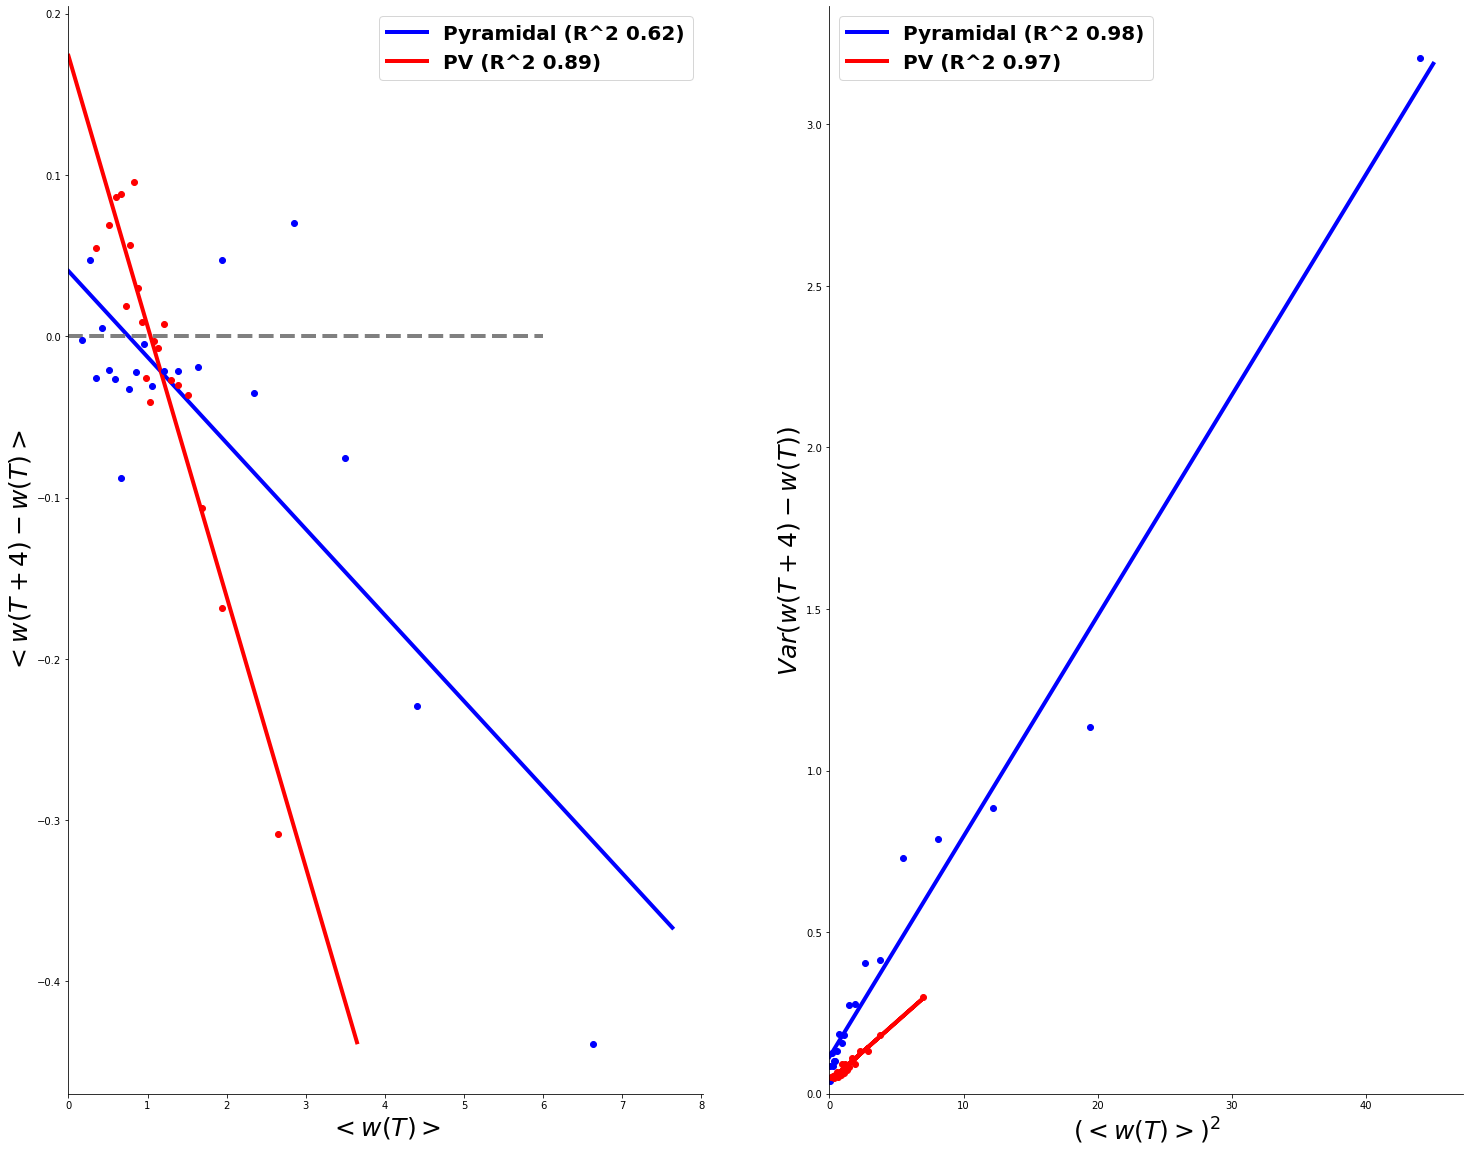

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(25, 20))

ax = plt.subplot(1, 2, 1)

plt.errorbar(
    Pyr_Control.kesten_mean_X_test, Pyr_Control.kesten_mean_Y_test, color="b", marker="o", ls="none"
)
my_Pyr_mean_X_test = np.expand_dims(np.linspace(0, np.amax(Pyr_Control.kesten_mean_X_test)+1, 20), axis=-1)
plt.plot(my_Pyr_mean_X_test, Pyr_Control.kesten_mean_line(my_Pyr_mean_X_test), 
         linewidth=4.0, color="b", 
         label="Pyramidal (R^2 {:.2f})".format(Pyr_Control.kesten_mean_test_rsquared))

plt.errorbar(
    PV_Control.kesten_mean_X_test, PV_Control.kesten_mean_Y_test, color="r", marker="o", ls="none"
)
my_PV_mean_X_test = np.expand_dims(np.linspace(0, np.amax(PV_Control.kesten_mean_X_test)+1, 20), axis=-1)
plt.plot(my_PV_mean_X_test, PV_Control.kesten_mean_line(my_PV_mean_X_test), 
         linewidth=4.0, color="r", 
         label="PV (R^2 {:.2f})".format(PV_Control.kesten_mean_test_rsquared))

xs = np.linspace(0, 6, 100)
plt.plot(xs, np.array([0.0 for v in range(len(xs))]), 
         color='gray', ls="--", linewidth=4.0)
         
plt.xlabel("$<w(T)>$", fontsize=25, fontweight="bold")
plt.ylabel("$<w(T+4) - w(T)>$", fontsize=25, fontweight="bold")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(prop={'weight':'bold', 'size':20}, loc='best')
plt.gca().set_xlim(left=0)

ax = plt.subplot(1, 2, 2)
plt.errorbar(
    Pyr_Control.kesten_var_X_test, Pyr_Control.kesten_var_Y_test, color="b", marker="o", ls="none"
)
my_Pyr_var_X_test = np.expand_dims(np.linspace(0, np.amax(Pyr_Control.kesten_var_X_test)+1, 20), axis=-1)
plt.plot(my_Pyr_var_X_test, Pyr_Control.kesten_var_line(my_Pyr_var_X_test), 
         linewidth=4.0, color="b", 
         label="Pyramidal (R^2 {:.2f})".format(Pyr_Control.kesten_var_test_rsquared))

plt.errorbar(
    PV_Control.kesten_var_X_test, PV_Control.kesten_var_Y_test, color="r", marker="o", ls="none"
)
plt.plot(PV_Control.kesten_var_X_test, PV_Control.kesten_var_line_test, 
         linewidth=4.0, color="r", 
         label="PV (R^2 {:.2f})".format(PV_Control.kesten_var_test_rsquared))

plt.xlabel("$(<w(T)>)^2$", fontsize=25, fontweight="bold")
plt.ylabel("$Var(w(T+4) - w(T))$", fontsize=25, fontweight="bold")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(prop={'weight':'bold', 'size':20}, loc='best')
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

plt.show()